In [80]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

# Fluctuation analysis for adapted-levels algorithm
In this section we will do some analysis of the comportment of $\sqrt N\frac{\hat p - p}{p}$. In the idealized situation, by the thm of CTL, it converges to a normal law and we are interested in estimating the variance of this normal distribution.

In [81]:
from numba import autojit
@autojit
def S(X):
    '''score function which is a black box'''
    return np.abs(X)

In [130]:
q_test = 2.5
from scipy.stats import norm
p = (1-norm.cdf(q_test))*2

p_0 = 0.75 #success rate
n_0 = int(np.log(p)/np.log(p_0))
r = p/(p_0**n_0)
sigma_theoretical = np.sqrt(n_0*(1-p_0)/p_0 + (1-r)/r)
print ("theoretical relative standard variation: ", sigma_theoretical)
print "real value of p:" ,p

('theoretical relative standard variation: ', 2.2530026706756048)
real value of p: 0.0124193306516


In [112]:
def mu_0_test(N,q_test):
    '''The distribution of X that we could simulate'''
    ## To ensure that L_k != empty
    X = np.random.normal(0,1,N)
    while(np.sum((S(X)>q_test)) == 0):
        X = np.random.normal(0,1,N)
    return X


def L_empirical(X,alpha, N, score_function):  
    return np.sort(score_function(X))[np.int((1-alpha)*N)]


def simulation_adapted_levels(real_p, p_0, N, mu_0, q_test, score_function, status_track = False):
    X = mu_0(N,q_test)
    L = np.array([-np.Inf,L_empirical(X ,p_0 ,N,score_function )])
    k = 1

    while(L[k]<q_test):
        if status_track == True:
            print "\t"
            print "k = ",k
            print 'current level: ', L[k]
        I = []
        for i in range(N):
            if S(X[i])>L[k]:
                I = np.append(I, X[i])
        l = len(I)
        X[0:l] = I

    ###### permutation trick to replace multinominal distribution
        I = np.random.permutation(I)
        for i in range(l,N,1):
            X[i] = I[i%l]    
        L = np.append(L, L_empirical(X,p_0 ,N,score_function))
        k += 1
    N_L = np.sum((S(X)>q_test))
    p_hat = N_L/float(N)*p_0**(k-1)
    rel_var = (p_hat-real_p)/real_p
#     L_adapted = L[0:-1]
#     L_adapted = np.append(L_adapted, q_test)
    
    if status_track ==True:
        print ("final k = ",k)
        print ("real value of p:" ,p)
        print ("estimation of p: ", p_hat)
        print ("sqrt(N) * relative variation: ",rel_var * np.sqrt(N))
    return p_hat, rel_var


In [139]:
#test
simulation_adapted_levels(real_p = p, p_0 = 0.75, N = 10000, mu_0 = mu_0_test,
                          q_test = 2.5, score_function = S, status_track = True)

	
k =  1
current level:  0.313539567946
	
k =  2
current level:  0.572440700465
	
k =  3
current level:  0.791026727768
	
k =  4
current level:  0.992470417156
	
k =  5
current level:  1.1839029327
	
k =  6
current level:  1.35089794699
	
k =  7
current level:  1.51766960029
	
k =  8
current level:  1.67578284527
	
k =  9
current level:  1.81600011573
	
k =  10
current level:  1.9474863888
	
k =  11
current level:  2.08267028288
	
k =  12
current level:  2.19735592428
	
k =  13
current level:  2.30398826434
	
k =  14
current level:  2.39721083942
	
k =  15
current level:  2.48934222095
('final k = ', 16)
('real value of p:', 0.012419330651552318)
('estimation of p: ', 0.012827586223650723)
('sqrt(N) * relative variation: ', 3.287259060514474)


(0.012827586223650723, 0.03287259060514474)

In [140]:
list_N = [100,500,1000,3000]
n_choice_N = len(list_N)
n_sim = 1000
#N = 100, 1000, 10000, 100000
sim_N =[[ [] for j in range(n_sim)] for i in range(n_choice_N)]
print ("Total number of simulation: ", n_choice_N)
for index_sim in range(n_choice_N):
    for i in range(n_sim):
        sim_N[index_sim][i] = simulation_adapted_levels(real_p = p ,p_0 = 0.75, N = list_N[index_sim],
                                  mu_0 = mu_0_test, q_test = 2.5, score_function = S, status_track = False)
        
    print ("simulation completed: ",index_sim+1)
sim_N = np.array(sim_N)

('Total number of simulation: ', 4)
('simulation completed: ', 1)
('simulation completed: ', 2)
('simulation completed: ', 3)
('simulation completed: ', 4)


In [141]:
estimation_sim = np.array([sim_N[i][:,0] for i in range(n_choice_N)])
sigma_relative_variation_sim = np.array([sim_N[i][:,1] * np.sqrt(list_N[i]) for i in range(n_choice_N)]) 
print ("theoretical std of relative variation: ", sigma_theoretical)
std_sqrtN = np.array([np.std(sigma_relative_variation_sim[i]) for i in range(n_choice_N)])
print ("\sqrt N * std of relative variation : ", std_sqrtN )

('theoretical std of relative variation: ', 2.2530026706756048)
('\\sqrt N * std of relative variation : ', array([ 10.86115875,  10.88210054,  11.00905125,  10.76144797]))


## Fluctuation Analysis

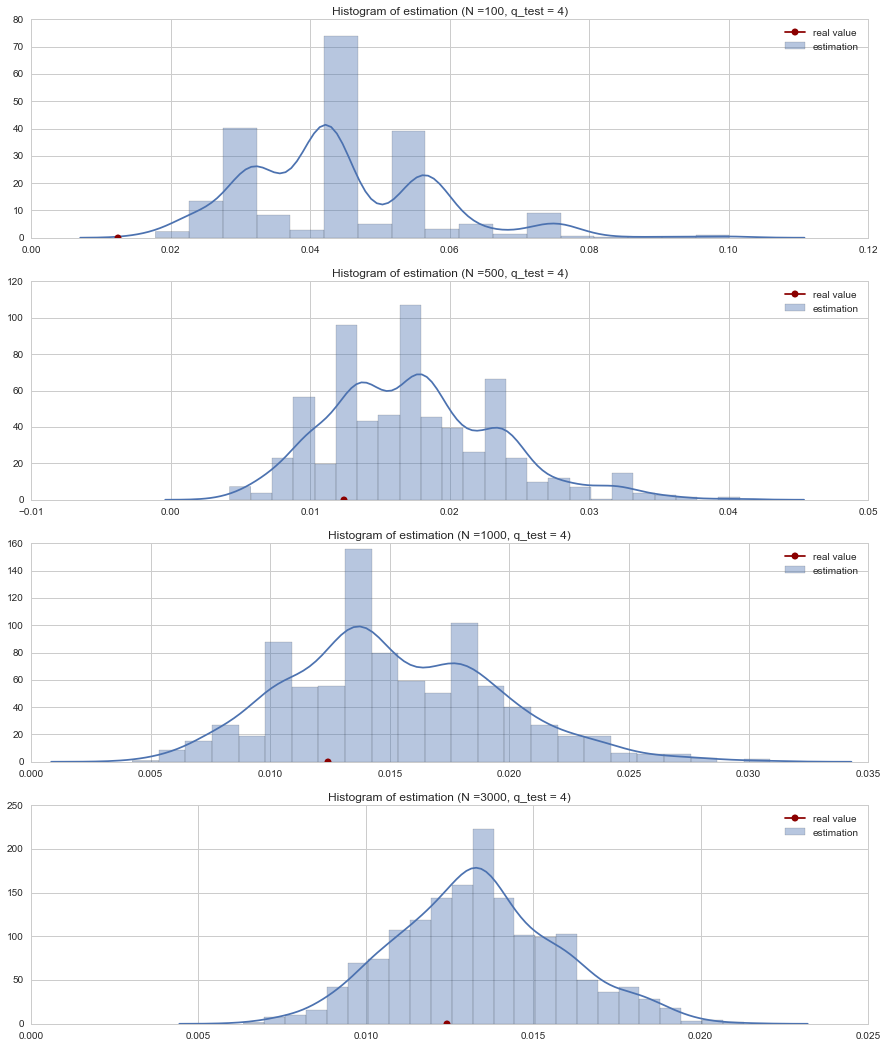

In [147]:
##fluctuation
plt.figure(figsize = [15,18])
for i in range(n_choice_N):
    plt.subplot(n_choice_N,1,i+1)

    sns.distplot(estimation_sim[i] , label = "estimation")
    plt.title('Histogram of estimation (N ='+str(list_N[i])+', q_test = 4)')
    x = np.arange(-1,1,0.1)
    plt.plot(p,0,marker = "o",color = 'darkred',label = "real value")
    plt.legend()
    #plt.xlim([-0.3,0.3])




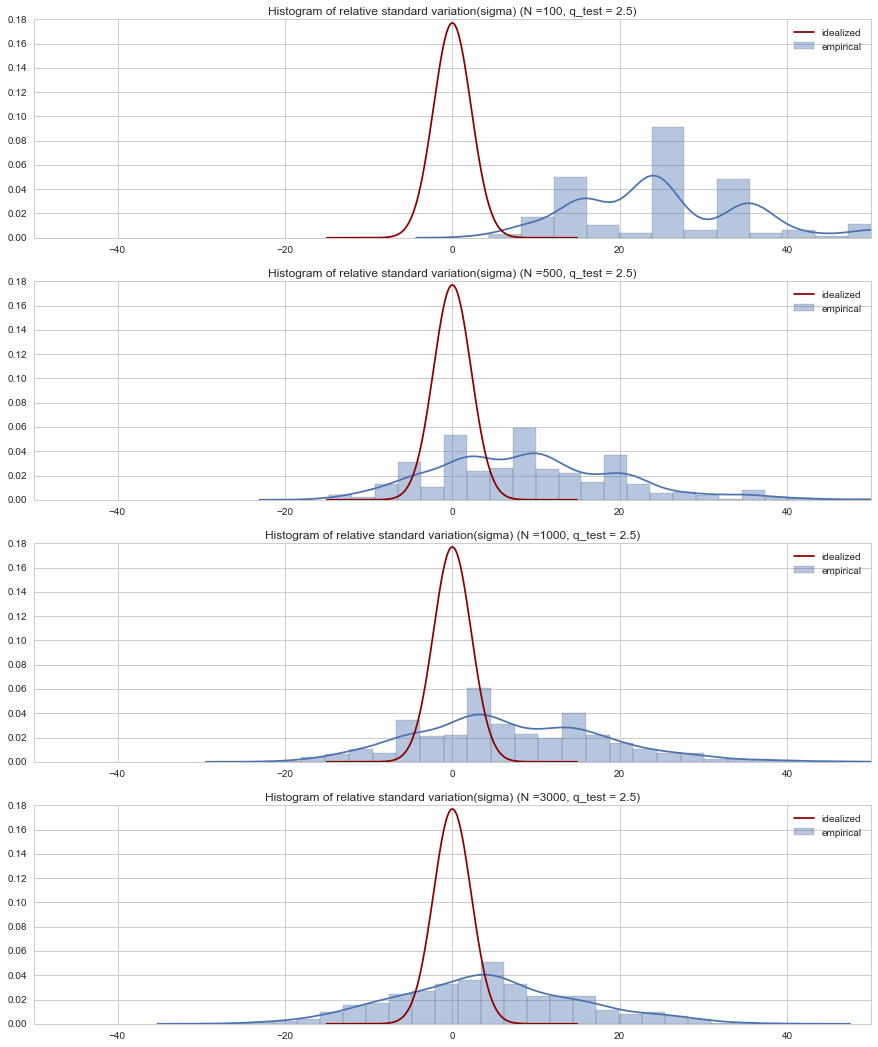

In [152]:
##fluctuation of variance(sigma)
plt.figure(figsize = [15,18])
for i in range(n_choice_N):
    plt.subplot(n_choice_N,1,i+1)

    sns.distplot(sigma_relative_variation_sim[i] , label = "empirical")
    plt.title('Histogram of relative standard variation(sigma) (N ='+str(list_N[i])+', q_test = 2.5)')
    x = np.arange(-15,15,0.1)
    plt.plot(x,norm.pdf(x,0,sigma_theoretical), label = "idealized", color = "darkred")
    plt.legend()
    plt.xlim([-50,50])




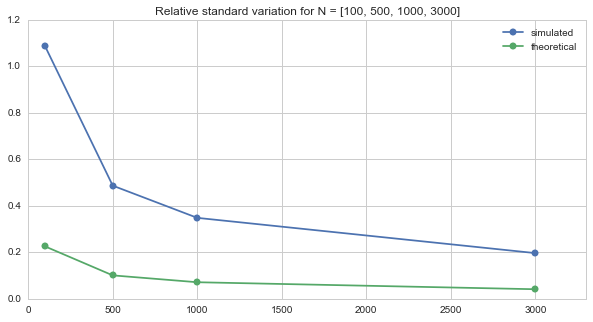

In [149]:
plt.figure(figsize = [10,5])
plt.plot(list_N, std_sqrtN/ np.sqrt(list_N), label = "simulated", marker = 'o')
plt.plot(list_N,  sigma_theoretical /np.sqrt(list_N), label = "theoretical", marker = 'o'    ) 
plt.legend()
plt.xlim([0,3300])
plt.title("Relative standard variation for N = "+str(list_N))

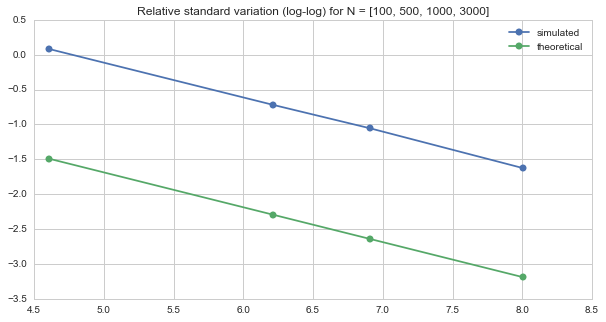

In [150]:
plt.figure(figsize = [10,5])
plt.plot(np.log(list_N), np.log(std_sqrtN/ np.sqrt(list_N)), label = "simulated", marker = 'o')
plt.plot(np.log(list_N),  np.log(sigma_theoretical /np.sqrt(list_N)), label = "theoretical", marker = 'o'    ) 
plt.legend()
plt.title("Relative standard variation (log-log) for N = "+str(list_N))

In [161]:
np.mean(estimation_sim[3])

0.013372036052309268